In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

/home/zeyadcode_jammy/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


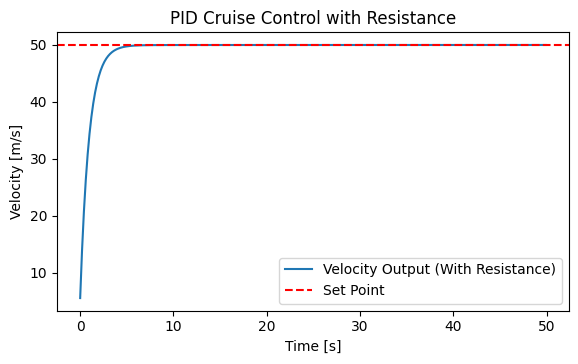

In [ ]:
class CarlaVehicleControl(Node):
    def __init__(self):
        super().__init__('carla_route_planner')
 
 
        # Subscribers
        self.initialpose_sub = self.create_subscription(
            PoseWithCovarianceStamped,
            '/initialpose',
            self.initialpose_callback,
            10
        )
        self.goal_pose_sub = self.create_subscription(
            PoseStamped,
            '/goal_pose',
            self.goal_pose_callback,
            10
        )
        self.waypt_sub = self.create_subscription(
            Path, 
            '/carla/ego_vehicle/waypoints', 
            self.waypoints_callback, 
            10
        )
        # Subscriber to the /carla/ego_vehicle/odometry topic
        self.odom_sub = self.create_subscription(
            Odometry,
            '/carla/ego_vehicle/odometry',
            self.odometry_callback,
            10)
 
 
        self.vehicle_control_publisher = self.create_publisher(CarlaEgoVehicleControl, 
                                                      '/carla/ego_vehicle/vehicle_control_cmd', 
                                                      10)
     
        # Initialize Carla client and map
        self.client = Client('localhost', 2000)
        self.client.set_timeout(10.0)
 
        # Get the current world
        self.world = self.client.get_world()
 
 
        # Check if Town01 is already loaded
        if 'Town01' not in self.world.get_map().name:
            print("Town01 is not loaded. Loading Town01...")
            self.world = self.client.load_world('Town01')
            print("Done!")
        else:
            print("Town01 is already loaded.")
 
 
        self.map = self.world.get_map()
        # Initialize GlobalRoutePlanner
        self.route_planner = GlobalRoutePlanner(self.map, 2.0)
 
        # Get all actors (vehicles, pedestrians, etc.) in the world
        self.actors = self.world.get_actors()
 
        # Filter to get only the vehicles get the 0-th veh as there is only one veh
        self.vehicle = self.actors.filter('vehicle.*')[0]
 
        # Placeholders for start and end poses
        self.start_pose = None
        self.end_pose = None
        self.waypoints_list = []
        self.odom = None
 
        # TF2 listener and buffer
        # self.tf_buffer = Buffer()
        # self.tf_listener = TransformListener(self.tf_buffer, self)
        # self.vehicle_loc = None
 
    def odometry_callback(self, msg):
         
         
        self.get_logger().info(f"Received odometry data: {msg.pose.pose.position.x}, {msg.pose.pose.position.y}, {msg.pose.pose.position.z}")
 
        # Extract position and orientation from Odometry message
        x = msg.pose.pose.position.x
        y = -msg.pose.pose.position.y
        z = msg.pose.pose.position.z
         
        print(" ^^^^ ODOM XYZ: ", x,y,z )
 
        orientation_q = msg.pose.pose.orientation
        roll, pitch, yaw = euler_from_quaternion(
            [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w])
 
        # Create a carla.Location object
        location = carla.Location(x=x, y=y, z=z)
 
        # Create a carla.Rotation object
        rotation = carla.Rotation(roll=roll, pitch=pitch, yaw=yaw)
 
        # Create a carla.Transform object
        transform = carla.Transform(location, rotation)
         
        self.odom = transform
 
    def waypoints_callback(self, msg):
        # self.waypoints_list.clear()  # Clear the list before storing new waypoints
 
        # Iterate through all the waypoints in the Path message
        for pose in msg.poses:
            # Extract the position from the pose
            x = pose.pose.position.x
            y = -pose.pose.position.y
            z = pose.pose.position.z
 
            # Extract the orientation (quaternion) from the pose
            orientation_q = pose.pose.orientation
            roll, pitch, yaw = euler_from_quaternion(
                [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w])
 
            # Create a carla.Location object
            location = carla.Location(x=x, y=y, z=z)
 
            # Create a carla.Rotation object
            rotation = carla.Rotation(roll=roll, pitch=pitch, yaw=yaw)
 
            # Create a carla.Transform object
            transform = carla.Transform(location, rotation)
 
            # Store the Waypoint in the global list
            self.waypoints_list.append(transform)
             
            self.get_logger().info(f"Stored {len(self.waypoints_list)} waypoints as carla.libcarla.Waypoint objects.")
 
    def create_ctrl_msg(self, throttle, steer, brake):
        control_msg = CarlaEgoVehicleControl()
        control_msg.throttle = throttle
        control_msg.steer = steer
        control_msg.brake = brake
        return control_msg
 
    def initialpose_callback(self, msg):
        self.get_logger().info("Received initialpose")
        self.start_pose = msg.pose.pose
 
    def goal_pose_callback(self, msg):
        self.get_logger().info("Received goal_pose")
        self.end_pose = msg.pose
        # Clear the waypoints list for the new goal
        self.waypoints_list.clear()
    def get_transform(self, vehicle_location, angle, d=6.4):
        a = math.radians(angle)
        location = carla.Location(
            d * math.cos(a), d * math.sin(a), 2.0) + vehicle_location
        return carla.Transform(location, carla.Rotation(yaw=180 + angle, pitch=-15))
 
    def setup_PID(self, vehicle):
        """
        This function creates a PID controller for the vehicle passed to it 
        """
        args_lateral_dict = {
            'K_P': 0.5,  # Reduced proportional gain for smoother steering
            'K_D': 0.1,  # Small derivative gain to dampen oscillations
            'K_I': 0.01, # Small integral gain to correct for long-term drift
            'dt': 0.05
        }
 
        args_long_dict = {
            'K_P': 0.2,  # Slightly lower gain for acceleration control
            'K_D': 0.3,  # Moderate derivative gain
            'K_I': 0.01, # Small integral gain
            'dt': 0.05
        }
 
        PID= VehiclePIDController(vehicle,args_lateral=args_lateral_dict,args_longitudinal=args_long_dict)
     
        return PID
     
     
    def find_dist_veh(self, vehicle_loc,target):
        dist = math.sqrt( (target.location.x - vehicle_loc.x)**2 + \
                         (target.location.y - vehicle_loc.y)**2 )
         
        return dist
 
 
    def drive_through_plan(self, planned_route, vehicle, speed, PID):
        """
        This function drives throught the planned_route with the speed passed in the argument
         
        """
         
        i=0
        waypt_cnt = len(planned_route)-1
        target=planned_route[0]
 
        cnt = 0
        while True:
             
            self.world.get_spectator().set_transform(self.get_transform(vehicle.get_location() +
                                                                carla.Location(z=1, x=0.5), 
                                                                vehicle.get_transform().rotation.yaw-180))
             
            # vehicle_loc =  vehicle.get_location()
            vehicle_loc =  self.odom.location
 
            distance_v = self.find_dist_veh(vehicle_loc,target)
             
 
            control = PID.run_step(speed,target)
            # vehicle.apply_control(control)
            ctrl_msg = self.create_ctrl_msg(control.throttle,
                                            control.steer,
                                            control.brake)
            self.vehicle_control_publisher.publish(ctrl_msg)
             
            if i==(len(planned_route)-1):
                print("last waypoint reached")
                break
             
             
            if (distance_v<3.5):
                 
                control = PID.run_step(speed,target)
                # vehicle.apply_control(control)
                ctrl_msg = self.create_ctrl_msg(control.throttle,
                            control.steer,
                            control.brake)
                self.vehicle_control_publisher.publish(ctrl_msg)
                i=i+1
                target=planned_route[i]
 
             
            if cnt%5==0:
                print("=----------------------------------------------------------")
                print(f"\n{GREEN} ***** from current loc to {i}/{waypt_cnt} waypoint distance: {distance_v}{RESET}\n")
                print("ROS2 vehilce location: ", self.odom.location)
                print("CARLA vehilce location: ", vehicle.get_location())
                print("target location: ", target.location)
                rclpy.spin_once(self)
             
            # time.sleep(0.1)  # Add a slight delay to reduce control frequency
            # time.sleep(1)  # Add a 1-second delay
             
            # print("throttle: ", control.throttle)
            cnt+=1
             
        control = PID.run_step(0,planned_route[len(planned_route)-1])
        # vehicle.apply_control(control)
        ctrl_msg = self.create_ctrl_msg(control.throttle,
                            control.steer,
                            control.brake)
        self.vehicle_control_publisher.publish(ctrl_msg)
 
 
    def run(self):
        desired_velocity=10 #Km/h
 
        while rclpy.ok():
            rclpy.spin_once(self)
             
            if self.start_pose is None or self.end_pose is None:
                self.get_logger().info(f'Start pose: {self.start_pose}, End pose: {self.end_pose}')
             
            elif not self.waypoints_list:
                self.get_logger().info('Waiting for waypoints to be generated...')
             
            else:
                # Delay to ensure waypoints are populated
                self.get_logger().info('Waiting a bit for waypoints to be fully populated...')
                time.sleep(1)  # Add a 1-second delay
                self.get_logger().info(f'Generated {len(self.waypoints_list)} waypoints from start to end pose')
                 
 
                # calculating life time of the marker
                total_dist = self.find_dist_veh(self.waypoints_list[0].location, self.waypoints_list[len(self.waypoints_list)-1])
                marker_life_time = (total_dist/desired_velocity) * 3.6
                 
 
                # Draw waypoints on the Carla map
                for w in self.waypoints_list:
                    # print("self.waypoints_list: ",w.location)
                    self.world.debug.draw_string(w.location, 'O', draw_shadow=False,
                                                 color=Color(r=255, g=0, b=0), life_time=5000000.0,
                                                 persistent_lines=True)
                 
                 
                # drive the vehicle
                PID=self.setup_PID(self.vehicle)
                self.drive_through_plan(self.waypoints_list,self.
                                        vehicle,desired_velocity,
                                        PID)
                 
 
                # After processing, break the loop if needed
                break
 
def main(args=None):
    rclpy.init(args=args)
    route_planner = CarlaVehicleControl()
    route_planner.run()
    rclpy.shutdown()